# Deep Convolutional GANs
Notes taken from a [tutorial by Jason Brownlee](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) and from the [TensorFlow Deep Conv GAN tutorial](https://www.tensorflow.org/tutorials/generative/dcgan). This DCGAN implementation reportedly took 28 hours to train, running on an Intel i7 8th gen CPU. So I also included an alternative implementation that is much, much faster. Alternative implementation of the generator and discriminator taken from this post by [David Gundisch](https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889)

The basic notion of GANs is that there are two networks competing against one another: a discriminator (the detective) and a generator (the forger). The generator aims to fool the discriminator by forging samples that are as realistic as possible. 

<img src="figures\GANs.png" width=800 /> [source](https://bdtechtalks.com/2018/05/28/generative-adversarial-networks-artificial-intelligence-ian-goodfellow/)

We'll use the MNIST dataset as an example - the generator will learn to produce realistic depictions of images of numbers, while the discriminator will judge its realism. We want the images produced by the generator to so realistic that the discriminator would unable to determine whether its real or not. 

Let's dive right in.

In [1]:
import keras
from keras.datasets import mnist
from keras import layers
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import sys
import numpy as np



## Inputs
First, define a function to load the MNIST dataset

In [2]:
def load_real_samples():
    # load mnist dataset
    (trainX, _), (_, _) = mnist.load_data()
    # expand to 3d, e.g. add channels dimension
    X = np.expand_dims(trainX, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X

## The discriminator
The discriminator looks at an image and computes a probability that the image is legit.
<img src="figures/GAN_discriminator.png" width=800> [source](https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889)

A note on LeakyReLU - The $\alpha$ parameter is the slope of the leaky ReLU function for x < 0. `alpha = 0.2` has been documented to work well for this activation.

In [3]:
# # the standalone discriminator model; each layer is conv->relu->dropout
# def build_discriminator(in_shape = (28,28,1)):
#     model = Sequential(name = 'discriminator')
#     #layer 1
#     model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape = in_shape))
#     model.add(layers.LeakyReLU(alpha = 0.2))
#     model.add(layers.Dropout(0.4))
#     # layer 2
#     model.add(layers.Conv2D(64, (3,3), strides=(2,2), padding='same'))
#     model.add(layers.LeakyReLU(alpha = 0.2))
#     model.add(layers.Dropout(0.4))
#     # classification
#     model.add(layers.Flatten())
#     model.add(layers.Dense(1, activation = 'sigmoid'))
    
#     # compile
#     opt = Adam(lr = 0.0002, beta_1 = 0.5)
#     model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
#     return model

# discriminator = build_discriminator()

The convolution implementation takes a long time to train, so here's a non-covolution alternative.

In [4]:
def build_discriminator(in_shape = (28,28,1)):
    model = Sequential(name = 'discriminator')
    model.add(layers.Flatten(input_shape=in_shape))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # compile
    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
    
discriminator = build_discriminator()

Let's test the discriminator on real images first.

In [5]:
# grab subset of real images
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

In [6]:
# generate n fake samples (w/ random numbers) and class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = np.random.rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

We can train the discriminator by grabbing real and fake samples over some number of iterations

In [7]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [8]:
# if you want, train the discriminator and see its performance

#dataset = load_real_samples()
#train_discriminator(discriminator,dataset)

Our discriminator seems to do pretty well.

# The generator
The generator takes noise and generators an image. Its layers should grow progressively larger, as in this example
<img src="figures/GAN_generator.png" width=800> [source](https://towardsdatascience.com/writing-your-first-generative-adversarial-network-with-keras-2d16fd8d4889)

The standalone generator doesn't do much, so we won't train it until it is combined with the discriminator

In [9]:
# # noise -> generator -> output image
# def build_generator(latent_dim):
#     model = Sequential()
#     # 7x7 image, 128 filters
#     n_nodes = 128*7*7
#     model.add(layers.Dense(n_nodes, input_dim=latent_dim))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     model.add(layers.Reshape((7,7,128)))
#     # upsample to 14x14
#     model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     # upsample to 28x28
#     model.add(layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
#     model.add(layers.LeakyReLU(alpha=0.2))
#     # output layer
#     model.add(layers.Conv2D(1,(7,7), activation='sigmoid', padding = 'same'))
    
#     return model

# latent_dim = 100
# generator = build_generator(latent_dim)
# # plot_model(generator, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# alternative implementation
def build_generator(latent_dim):
    img_shape = (28,28,1)
    model = Sequential(name = 'generator')

    # layer 1
    model.add(layers.Dense(256, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    
    # layer 2
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    
    # layer 3
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    
    # output layer
    model.add(layers.Dense(np.prod(img_shape), activation='tanh'))
    model.add(layers.Reshape(img_shape))
    
    return model

latent_dim = 100
generator = build_generator(latent_dim)

## Combine the generator with the discriminator

We freeze the weights of the discriminator so they won't be updated. Doing so will only freeze its weights in the combined GAN model, not the standalone model.

The "freezing" of layers occurs after a model has been compiled.

side note: Compile defines the loss function, the optimizer and the metrics. You need a compiled model to train (because training uses the loss function and the optimizer). But it's not necessary to compile a model for predicting [[source]](https://stackoverflow.com/questions/47995324/does-model-compile-initialize-all-the-weights-and-biases-in-keras-tensorflow#:~:text=Compile%20defines%20the%20loss%20function,loss%20function%20and%20the%20optimizer).

In [13]:
# the GAN model: noise -> generator -> fake image -> discriminator -> (0/1) validity
def build_GAN(generator,discriminator):
    # the combined network should not update the discriminator
    discriminator.trainable = False
    
    # connect the two models
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    opt = Adam(lr=0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = opt)
    
    return model

GAN = build_GAN(generator,discriminator)
# plot_model(GAN, to_file='GAN_model_plot.png', show_shapes=True, show_layer_names=True)

# Training the GAN
There are three separate training steps that has to occur for every iteration:
1. Update discriminator weights -> optimize real/fake detection
2. Freeze the discriminator
3. Update generator weights -> optimize image generation

We label the generated samples as real, because our goal is to generate images that can fool the discriminator. If the discriminator thinks the generated images are fake, then we'll get a large error, and we'll update the generator's weights accordingly. 

In [14]:
# this is like a custom .fit() function
def train(gen_model, disc_model, gan_model, dataset, latent_dim, num_epochs = 100, n_batch=128, sample_interval = 10):
    batch_per_epoch = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch/2)
    
    # use train_on_batch() rather than fit()
    # manually enumerate over epochs
    for epoch in range(num_epochs):
        for batch in range(batch_per_epoch):
            # grab real and fake samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
            
            # create training set for the discriminator
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            
            # update discriminator model weight
            d_loss, _ = disc_model.train_on_batch(X, y)
            
            # get input & labels for GAN
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (epoch+1, batch+1, batch_per_epoch, d_loss, g_loss))

        # summarize loss, performance, etc
        if epoch % sample_interval == 0:
            summarize_performance(epoch,gen_model,disc_model,dataset,latent_dim)
            sample_images(epoch)
    
    filename = 'generator_model.h5'
    gan_mode.save(filename)

In [15]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [16]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y

## Monitor and Evaluate the GAN model
In general, evaluting the GAN's performance is very subjective. So the standard practice is to save the generator, the image it generats, and the discriminator accuracy every n epochs. Let's write a function to do this.

We also report the loss on each batch. It is critical to keep an eye on the loss over batches. The reason for this is that *a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate*.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [17]:
# prints performance of discriminator
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [18]:
def sample_images(epoch):
    print("sampling")
    r, c = 10, 10
    noise = np.random.normal(0, 1, (r * c, latent_dim))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig("images/%d.png" % epoch)
    plt.close()


The original post trained the alternative implementation for 100,000 epochs.

In [ ]:
dataset = load_real_samples()
train(generator, discriminator, GAN, dataset, latent_dim,
     num_epochs = 100, n_batch=128, sample_interval = 10)

>1, 1/468, d=0.150, g=8.092
>1, 2/468, d=0.075, g=8.233
>1, 3/468, d=0.125, g=10.475
>1, 4/468, d=0.140, g=8.044
>1, 5/468, d=0.115, g=7.378
>1, 6/468, d=0.167, g=9.499
>1, 7/468, d=0.221, g=8.695
>1, 8/468, d=0.175, g=8.458
>1, 9/468, d=0.106, g=8.038
>1, 10/468, d=0.066, g=10.161
>1, 11/468, d=0.073, g=7.214
>1, 12/468, d=0.070, g=7.425
>1, 13/468, d=0.068, g=6.579
>1, 14/468, d=0.027, g=6.158
>1, 15/468, d=0.055, g=6.506
>1, 16/468, d=0.092, g=6.786
>1, 17/468, d=0.044, g=5.194
>1, 18/468, d=0.111, g=9.495
>1, 19/468, d=0.095, g=5.460
>1, 20/468, d=0.107, g=7.094
>1, 21/468, d=0.049, g=8.598
>1, 22/468, d=0.117, g=5.579
>1, 23/468, d=0.054, g=6.382
>1, 24/468, d=0.107, g=6.866
>1, 25/468, d=0.111, g=6.257
>1, 26/468, d=0.107, g=3.873
>1, 27/468, d=0.175, g=9.197
>1, 28/468, d=0.258, g=9.185
>1, 29/468, d=0.115, g=7.652
>1, 30/468, d=0.060, g=6.180
>1, 31/468, d=0.070, g=6.720
>1, 32/468, d=0.108, g=6.107
>1, 33/468, d=0.088, g=6.847
>1, 34/468, d=0.087, g=5.865
>1, 35/468, d=0.121, 

>1, 279/468, d=0.278, g=11.444
>1, 280/468, d=0.111, g=7.716
>1, 281/468, d=0.198, g=10.157
>1, 282/468, d=0.173, g=8.716
>1, 283/468, d=0.053, g=6.811
>1, 284/468, d=0.154, g=10.241
>1, 285/468, d=0.199, g=7.873
>1, 286/468, d=0.101, g=7.881
>1, 287/468, d=0.109, g=7.066
>1, 288/468, d=0.145, g=8.011
>1, 289/468, d=0.099, g=7.094
>1, 290/468, d=0.076, g=8.301
>1, 291/468, d=0.107, g=6.694
>1, 292/468, d=0.092, g=6.082
>1, 293/468, d=0.148, g=9.448
>1, 294/468, d=0.256, g=6.519
>1, 295/468, d=0.149, g=7.929
>1, 296/468, d=0.139, g=5.363
>1, 297/468, d=0.107, g=19.838
>1, 298/468, d=0.112, g=28.451
>1, 299/468, d=0.050, g=9.595
>1, 300/468, d=0.054, g=8.109
>1, 301/468, d=0.056, g=8.021
>1, 302/468, d=0.097, g=8.434
>1, 303/468, d=0.160, g=9.031
>1, 304/468, d=0.151, g=9.707
>1, 305/468, d=0.057, g=6.379
>1, 306/468, d=0.140, g=10.110
>1, 307/468, d=0.070, g=8.483
>1, 308/468, d=0.105, g=9.455
>1, 309/468, d=0.060, g=7.098
>1, 310/468, d=0.159, g=7.440
>1, 311/468, d=0.130, g=7.556
>1, 

>2, 84/468, d=0.066, g=7.546
>2, 85/468, d=0.089, g=7.145
>2, 86/468, d=0.150, g=4.012
>2, 87/468, d=0.277, g=10.512
>2, 88/468, d=0.444, g=4.049
>2, 89/468, d=0.116, g=5.218
>2, 90/468, d=0.185, g=8.953
>2, 91/468, d=0.180, g=6.355
>2, 92/468, d=0.132, g=5.728
>2, 93/468, d=0.167, g=8.230
>2, 94/468, d=0.134, g=6.702
>2, 95/468, d=0.131, g=8.371
>2, 96/468, d=0.094, g=7.754
>2, 97/468, d=0.114, g=5.861
>2, 98/468, d=0.098, g=9.748
>2, 99/468, d=0.098, g=6.506
>2, 100/468, d=0.114, g=5.863
>2, 101/468, d=0.112, g=7.999
>2, 102/468, d=0.143, g=7.214
>2, 103/468, d=0.083, g=6.452
>2, 104/468, d=0.060, g=6.869
>2, 105/468, d=0.103, g=6.743
>2, 106/468, d=0.096, g=7.762
>2, 107/468, d=0.055, g=6.465
>2, 108/468, d=0.066, g=15.250
>2, 109/468, d=0.100, g=8.944
>2, 110/468, d=0.054, g=9.409
>2, 111/468, d=0.093, g=16.637
>2, 112/468, d=0.072, g=7.150
>2, 113/468, d=0.130, g=6.208
>2, 114/468, d=0.098, g=13.635
>2, 115/468, d=0.081, g=7.920
>2, 116/468, d=0.063, g=5.421
>2, 117/468, d=0.099, 

>2, 357/468, d=0.036, g=10.595
>2, 358/468, d=0.068, g=9.283
>2, 359/468, d=0.072, g=6.987
>2, 360/468, d=0.084, g=5.117
>2, 361/468, d=0.084, g=8.589
>2, 362/468, d=0.073, g=6.290
>2, 363/468, d=0.037, g=9.016
>2, 364/468, d=0.118, g=5.236
>2, 365/468, d=0.145, g=7.103
>2, 366/468, d=0.075, g=6.954
>2, 367/468, d=0.089, g=6.108
>2, 368/468, d=0.087, g=7.824
>2, 369/468, d=0.090, g=8.276
>2, 370/468, d=0.049, g=7.946
>2, 371/468, d=0.061, g=11.532
>2, 372/468, d=0.071, g=7.685
>2, 373/468, d=0.081, g=6.447
>2, 374/468, d=0.067, g=7.751
>2, 375/468, d=0.090, g=6.686
>2, 376/468, d=0.062, g=6.332
>2, 377/468, d=0.086, g=6.477
>2, 378/468, d=0.092, g=5.852
>2, 379/468, d=0.091, g=8.670
>2, 380/468, d=0.089, g=5.241
>2, 381/468, d=0.084, g=6.869
>2, 382/468, d=0.127, g=6.467
>2, 383/468, d=0.082, g=5.987
>2, 384/468, d=0.061, g=6.857
>2, 385/468, d=0.114, g=6.614
>2, 386/468, d=0.048, g=8.143
>2, 387/468, d=0.063, g=7.122
>2, 388/468, d=0.083, g=10.574
>2, 389/468, d=0.045, g=11.410
>2, 39

>3, 167/468, d=0.076, g=6.892
>3, 168/468, d=0.119, g=9.059
>3, 169/468, d=0.069, g=5.109
>3, 170/468, d=0.071, g=7.956
>3, 171/468, d=0.104, g=7.731
>3, 172/468, d=0.132, g=4.158
>3, 173/468, d=0.087, g=5.431
>3, 174/468, d=0.199, g=10.277
>3, 175/468, d=0.091, g=5.057
>3, 176/468, d=0.102, g=5.105
>3, 177/468, d=0.208, g=11.848
>3, 178/468, d=0.379, g=5.874
>3, 179/468, d=0.171, g=5.694
>3, 180/468, d=0.082, g=10.017
>3, 181/468, d=0.140, g=8.398
>3, 182/468, d=0.087, g=8.194
>3, 183/468, d=0.071, g=7.740
>3, 184/468, d=0.091, g=7.487
>3, 185/468, d=0.051, g=38.078
>3, 186/468, d=0.050, g=42.528
>3, 187/468, d=0.047, g=61.496
>3, 188/468, d=0.041, g=40.381
>3, 189/468, d=0.032, g=40.742
>3, 190/468, d=0.059, g=26.707
>3, 191/468, d=0.048, g=32.605
>3, 192/468, d=0.074, g=14.629
>3, 193/468, d=0.042, g=11.036
>3, 194/468, d=0.032, g=9.625
>3, 195/468, d=0.095, g=8.847
>3, 196/468, d=0.104, g=10.724
>3, 197/468, d=0.097, g=11.109
>3, 198/468, d=0.069, g=8.706
>3, 199/468, d=0.095, g=9.

>3, 438/468, d=0.160, g=10.078
>3, 439/468, d=0.109, g=9.052
>3, 440/468, d=0.085, g=8.608
>3, 441/468, d=0.130, g=8.076
>3, 442/468, d=0.071, g=7.693
>3, 443/468, d=0.048, g=9.345
>3, 444/468, d=0.115, g=9.947
>3, 445/468, d=0.217, g=7.505
>3, 446/468, d=0.145, g=9.376
>3, 447/468, d=0.304, g=7.473
>3, 448/468, d=0.140, g=8.871
>3, 449/468, d=0.153, g=9.932
>3, 450/468, d=0.104, g=6.050
>3, 451/468, d=0.163, g=9.163
>3, 452/468, d=0.121, g=6.498
>3, 453/468, d=0.124, g=7.695
>3, 454/468, d=0.096, g=7.205
>3, 455/468, d=0.150, g=8.675
>3, 456/468, d=0.119, g=9.169
>3, 457/468, d=0.176, g=6.279
>3, 458/468, d=0.164, g=8.636
>3, 459/468, d=0.167, g=9.234
>3, 460/468, d=0.095, g=8.121
>3, 461/468, d=0.094, g=6.457
>3, 462/468, d=0.110, g=4.777
>3, 463/468, d=0.266, g=10.193
>3, 464/468, d=0.344, g=4.769
>3, 465/468, d=0.283, g=8.712
>3, 466/468, d=0.241, g=6.399
>3, 467/468, d=0.166, g=7.207
>3, 468/468, d=0.117, g=8.486
>4, 1/468, d=0.111, g=8.566
>4, 2/468, d=0.126, g=6.392
>4, 3/468, d

>4, 247/468, d=0.121, g=5.050
>4, 248/468, d=0.092, g=6.940
>4, 249/468, d=0.141, g=8.298
>4, 250/468, d=0.165, g=7.411
>4, 251/468, d=0.122, g=5.957
>4, 252/468, d=0.056, g=5.801
>4, 253/468, d=0.088, g=7.086
>4, 254/468, d=0.140, g=5.598
>4, 255/468, d=0.100, g=6.641
>4, 256/468, d=0.137, g=6.807
>4, 257/468, d=0.096, g=4.681
>4, 258/468, d=0.112, g=6.654
>4, 259/468, d=0.178, g=4.818
>4, 260/468, d=0.113, g=6.928
>4, 261/468, d=0.109, g=5.134
>4, 262/468, d=0.087, g=5.510
>4, 263/468, d=0.086, g=4.799
>4, 264/468, d=0.074, g=6.400
>4, 265/468, d=0.057, g=6.796
>4, 266/468, d=0.069, g=6.265
>4, 267/468, d=0.067, g=5.853
>4, 268/468, d=0.063, g=7.199
>4, 269/468, d=0.059, g=6.783
>4, 270/468, d=0.049, g=6.031
>4, 271/468, d=0.095, g=5.677
>4, 272/468, d=0.067, g=5.925
>4, 273/468, d=0.095, g=7.239
>4, 274/468, d=0.130, g=5.220
>4, 275/468, d=0.105, g=7.102
>4, 276/468, d=0.074, g=5.463
>4, 277/468, d=0.088, g=6.573
>4, 278/468, d=0.116, g=5.963
>4, 279/468, d=0.096, g=7.286
>4, 280/46

>5, 55/468, d=0.102, g=7.124
>5, 56/468, d=0.058, g=10.710
>5, 57/468, d=0.082, g=8.493
>5, 58/468, d=0.095, g=7.416
>5, 59/468, d=0.129, g=6.242
>5, 60/468, d=0.072, g=5.302
>5, 61/468, d=0.106, g=7.025
>5, 62/468, d=0.111, g=4.871
>5, 63/468, d=0.150, g=6.225
>5, 64/468, d=0.125, g=5.041
>5, 65/468, d=0.083, g=6.682
>5, 66/468, d=0.152, g=7.457
>5, 67/468, d=0.108, g=8.337
>5, 68/468, d=0.089, g=6.231
>5, 69/468, d=0.104, g=13.789
>5, 70/468, d=0.154, g=7.658
>5, 71/468, d=0.076, g=11.368
>5, 72/468, d=0.088, g=10.656
>5, 73/468, d=0.076, g=9.060
>5, 74/468, d=0.054, g=12.094
>5, 75/468, d=0.102, g=7.796
>5, 76/468, d=0.074, g=8.781
>5, 77/468, d=0.074, g=5.975
>5, 78/468, d=0.067, g=5.431
>5, 79/468, d=0.082, g=8.793
>5, 80/468, d=0.176, g=4.805
>5, 81/468, d=0.133, g=8.241
>5, 82/468, d=0.114, g=4.992
>5, 83/468, d=0.090, g=9.521
>5, 84/468, d=0.094, g=10.671
>5, 85/468, d=0.207, g=7.654
>5, 86/468, d=0.184, g=8.711
>5, 87/468, d=0.126, g=9.600
>5, 88/468, d=0.075, g=11.895
>5, 89/

>5, 330/468, d=0.173, g=6.492
>5, 331/468, d=0.154, g=5.620
>5, 332/468, d=0.091, g=5.737
>5, 333/468, d=0.084, g=8.589
>5, 334/468, d=0.052, g=8.658
>5, 335/468, d=0.081, g=8.546
>5, 336/468, d=0.104, g=7.134
>5, 337/468, d=0.101, g=5.734
>5, 338/468, d=0.064, g=6.088
>5, 339/468, d=0.089, g=6.504
>5, 340/468, d=0.072, g=6.270
>5, 341/468, d=0.074, g=4.381
>5, 342/468, d=0.079, g=5.411
>5, 343/468, d=0.082, g=5.865
>5, 344/468, d=0.143, g=4.063
>5, 345/468, d=0.176, g=10.666
>5, 346/468, d=0.241, g=4.934
>5, 347/468, d=0.179, g=6.564
>5, 348/468, d=0.107, g=5.790
>5, 349/468, d=0.092, g=5.667
>5, 350/468, d=0.248, g=11.221
>5, 351/468, d=0.331, g=8.503
>5, 352/468, d=0.088, g=4.921
>5, 353/468, d=0.215, g=12.056
>5, 354/468, d=0.615, g=7.671
>5, 355/468, d=0.313, g=15.102
>5, 356/468, d=1.241, g=16.705
>5, 357/468, d=0.780, g=18.504
>5, 358/468, d=0.729, g=13.169
>5, 359/468, d=1.200, g=24.089
>5, 360/468, d=1.867, g=11.754
>5, 361/468, d=0.460, g=11.720
>5, 362/468, d=0.800, g=6.196


>6, 138/468, d=0.065, g=7.438
>6, 139/468, d=0.089, g=7.513
>6, 140/468, d=0.070, g=7.446
>6, 141/468, d=0.069, g=6.850
>6, 142/468, d=0.113, g=6.553
>6, 143/468, d=0.121, g=7.434
>6, 144/468, d=0.071, g=5.834
>6, 145/468, d=0.111, g=6.494
>6, 146/468, d=0.161, g=5.557
>6, 147/468, d=0.119, g=6.864
>6, 148/468, d=0.137, g=5.785
>6, 149/468, d=0.087, g=6.566
>6, 150/468, d=0.096, g=9.628
>6, 151/468, d=0.083, g=6.225
>6, 152/468, d=0.078, g=6.975
>6, 153/468, d=0.067, g=5.969
>6, 154/468, d=0.197, g=8.234
>6, 155/468, d=0.111, g=6.567
>6, 156/468, d=0.073, g=5.402
>6, 157/468, d=0.123, g=9.213
>6, 158/468, d=0.098, g=7.672
>6, 159/468, d=0.092, g=8.045
>6, 160/468, d=0.130, g=7.665
>6, 161/468, d=0.091, g=7.243
>6, 162/468, d=0.086, g=7.217
>6, 163/468, d=0.145, g=4.958
>6, 164/468, d=0.164, g=8.595
>6, 165/468, d=0.315, g=3.571
>6, 166/468, d=0.230, g=7.685
>6, 167/468, d=0.280, g=4.495
>6, 168/468, d=0.277, g=9.293
>6, 169/468, d=0.202, g=7.494
>6, 170/468, d=0.116, g=5.964
>6, 171/46

>6, 411/468, d=0.085, g=7.219
>6, 412/468, d=0.052, g=8.582
>6, 413/468, d=0.109, g=8.637
>6, 414/468, d=0.095, g=8.148
>6, 415/468, d=0.092, g=8.019
>6, 416/468, d=0.144, g=6.636
>6, 417/468, d=0.154, g=6.260
>6, 418/468, d=0.104, g=9.336
>6, 419/468, d=0.078, g=8.129
>6, 420/468, d=0.087, g=7.343
>6, 421/468, d=0.074, g=6.425
>6, 422/468, d=0.088, g=6.960
>6, 423/468, d=0.062, g=5.855
>6, 424/468, d=0.100, g=5.570
>6, 425/468, d=0.095, g=5.243
>6, 426/468, d=0.085, g=7.924
>6, 427/468, d=0.213, g=5.285
>6, 428/468, d=0.152, g=7.698
>6, 429/468, d=0.076, g=8.606
>6, 430/468, d=0.156, g=6.041
>6, 431/468, d=0.155, g=7.283
>6, 432/468, d=0.112, g=9.886
>6, 433/468, d=0.291, g=4.044
>6, 434/468, d=0.306, g=9.402
>6, 435/468, d=0.286, g=7.093
>6, 436/468, d=0.051, g=5.788
>6, 437/468, d=0.147, g=8.160
>6, 438/468, d=0.085, g=8.840
>6, 439/468, d=0.125, g=5.455
>6, 440/468, d=0.126, g=8.670
>6, 441/468, d=0.086, g=7.274
>6, 442/468, d=0.053, g=8.569
>6, 443/468, d=0.082, g=9.794
>6, 444/46

>7, 219/468, d=0.087, g=8.309
>7, 220/468, d=0.065, g=6.934
>7, 221/468, d=0.094, g=11.323
>7, 222/468, d=0.071, g=6.175
>7, 223/468, d=0.059, g=7.118
>7, 224/468, d=0.089, g=6.872
>7, 225/468, d=0.055, g=6.090
>7, 226/468, d=0.076, g=6.170
>7, 227/468, d=0.117, g=8.271
>7, 228/468, d=0.092, g=6.321
>7, 229/468, d=0.070, g=5.680
>7, 230/468, d=0.146, g=7.833
>7, 231/468, d=0.149, g=6.607
>7, 232/468, d=0.125, g=3.370
>7, 233/468, d=0.174, g=7.686
>7, 234/468, d=0.096, g=9.162
>7, 235/468, d=0.321, g=6.702
>7, 236/468, d=0.437, g=13.738
>7, 237/468, d=0.395, g=9.303
>7, 238/468, d=0.097, g=9.377
>7, 239/468, d=0.149, g=7.425
>7, 240/468, d=0.180, g=7.378
>7, 241/468, d=0.061, g=7.671
>7, 242/468, d=0.108, g=6.560
>7, 243/468, d=0.198, g=10.783
>7, 244/468, d=0.140, g=8.108
>7, 245/468, d=0.111, g=6.006
>7, 246/468, d=0.117, g=9.420
>7, 247/468, d=0.121, g=8.817
>7, 248/468, d=0.103, g=6.793
>7, 249/468, d=0.161, g=9.542
>7, 250/468, d=0.157, g=7.055
>7, 251/468, d=0.058, g=6.490
>7, 252

>8, 25/468, d=0.067, g=5.432
>8, 26/468, d=0.060, g=6.385
>8, 27/468, d=0.083, g=5.918
>8, 28/468, d=0.088, g=5.180
>8, 29/468, d=0.032, g=6.967
>8, 30/468, d=0.131, g=4.280
>8, 31/468, d=0.130, g=7.473
>8, 32/468, d=0.220, g=3.150
>8, 33/468, d=0.263, g=8.050
>8, 34/468, d=0.261, g=5.832
>8, 35/468, d=0.141, g=4.641
>8, 36/468, d=0.200, g=9.887
>8, 37/468, d=0.485, g=3.694
>8, 38/468, d=0.468, g=12.099
>8, 39/468, d=0.829, g=10.373
>8, 40/468, d=0.070, g=4.101
>8, 41/468, d=0.433, g=10.028
>8, 42/468, d=0.551, g=5.769
>8, 43/468, d=0.241, g=7.736
>8, 44/468, d=0.128, g=10.576
>8, 45/468, d=0.255, g=6.501
>8, 46/468, d=0.109, g=5.829
>8, 47/468, d=0.131, g=9.487
>8, 48/468, d=0.095, g=7.560
>8, 49/468, d=0.083, g=6.902
>8, 50/468, d=0.110, g=8.385
>8, 51/468, d=0.076, g=8.664
>8, 52/468, d=0.055, g=6.261
>8, 53/468, d=0.074, g=7.760
>8, 54/468, d=0.127, g=8.252
>8, 55/468, d=0.116, g=7.317
>8, 56/468, d=0.066, g=6.506
>8, 57/468, d=0.069, g=7.117
>8, 58/468, d=0.107, g=7.951
>8, 59/468

>8, 301/468, d=0.086, g=8.531
>8, 302/468, d=0.074, g=6.563
>8, 303/468, d=0.046, g=9.394
>8, 304/468, d=0.083, g=18.225
>8, 305/468, d=0.107, g=8.972
>8, 306/468, d=0.057, g=12.167
>8, 307/468, d=0.047, g=8.973
>8, 308/468, d=0.142, g=8.180
>8, 309/468, d=0.101, g=6.120
>8, 310/468, d=0.056, g=6.699
>8, 311/468, d=0.089, g=8.002
>8, 312/468, d=0.085, g=7.489
>8, 313/468, d=0.078, g=6.631
>8, 314/468, d=0.092, g=7.470
>8, 315/468, d=0.123, g=5.686
>8, 316/468, d=0.103, g=4.995
>8, 317/468, d=0.105, g=7.386
>8, 318/468, d=0.157, g=5.430
>8, 319/468, d=0.106, g=5.373
>8, 320/468, d=0.135, g=6.399
>8, 321/468, d=0.129, g=5.456
>8, 322/468, d=0.075, g=7.512
>8, 323/468, d=0.122, g=12.153
>8, 324/468, d=0.060, g=8.190
>8, 325/468, d=0.108, g=8.533
>8, 326/468, d=0.097, g=7.288
>8, 327/468, d=0.062, g=5.695
>8, 328/468, d=0.111, g=6.302
>8, 329/468, d=0.110, g=9.867
>8, 330/468, d=0.067, g=9.813
>8, 331/468, d=0.092, g=7.922
>8, 332/468, d=0.073, g=8.576
>8, 333/468, d=0.063, g=7.248
>8, 334

>9, 110/468, d=0.049, g=7.314
>9, 111/468, d=0.051, g=6.059
>9, 112/468, d=0.135, g=10.752
>9, 113/468, d=0.163, g=7.328
>9, 114/468, d=0.076, g=8.309
>9, 115/468, d=0.093, g=9.076
>9, 116/468, d=0.069, g=11.242
>9, 117/468, d=0.126, g=9.924
>9, 118/468, d=0.091, g=7.480
>9, 119/468, d=0.039, g=8.108
>9, 120/468, d=0.057, g=7.401
>9, 121/468, d=0.082, g=9.808
>9, 122/468, d=0.160, g=5.637
>9, 123/468, d=0.162, g=9.790
>9, 124/468, d=0.198, g=6.466
>9, 125/468, d=0.181, g=8.873
>9, 126/468, d=0.122, g=8.436
>9, 127/468, d=0.091, g=6.456
>9, 128/468, d=0.173, g=10.097
>9, 129/468, d=0.405, g=6.640
>9, 130/468, d=0.245, g=19.219
>9, 131/468, d=0.104, g=17.242
>9, 132/468, d=0.124, g=73.153
>9, 133/468, d=0.038, g=29.468
>9, 134/468, d=0.028, g=23.140
>9, 135/468, d=0.098, g=14.414
>9, 136/468, d=0.056, g=11.145
>9, 137/468, d=0.081, g=9.689
>9, 138/468, d=0.050, g=13.584
>9, 139/468, d=0.057, g=10.742
>9, 140/468, d=0.095, g=10.482
>9, 141/468, d=0.077, g=9.728
>9, 142/468, d=0.081, g=7.4

>9, 383/468, d=0.149, g=7.502
>9, 384/468, d=0.066, g=7.989
>9, 385/468, d=0.081, g=9.383
>9, 386/468, d=0.071, g=7.903
>9, 387/468, d=0.066, g=6.087
>9, 388/468, d=0.088, g=6.799
>9, 389/468, d=0.081, g=5.447
>9, 390/468, d=0.118, g=6.248
>9, 391/468, d=0.144, g=4.179
>9, 392/468, d=0.076, g=6.982
>9, 393/468, d=0.061, g=5.233
>9, 394/468, d=0.108, g=4.922
>9, 395/468, d=0.121, g=3.550
>9, 396/468, d=0.210, g=6.537
>9, 397/468, d=0.244, g=5.557
>9, 398/468, d=0.142, g=3.500
>9, 399/468, d=0.122, g=6.799
>9, 400/468, d=0.200, g=4.265
>9, 401/468, d=0.194, g=7.204
>9, 402/468, d=0.142, g=4.990
>9, 403/468, d=0.097, g=4.406
>9, 404/468, d=0.170, g=8.645
>9, 405/468, d=0.242, g=6.757
>9, 406/468, d=0.089, g=5.424
>9, 407/468, d=0.103, g=7.433
>9, 408/468, d=0.081, g=8.094
>9, 409/468, d=0.115, g=8.251
>9, 410/468, d=0.097, g=5.806
>9, 411/468, d=0.085, g=7.668
>9, 412/468, d=0.091, g=5.896
>9, 413/468, d=0.100, g=5.590
>9, 414/468, d=0.151, g=8.720
>9, 415/468, d=0.192, g=6.803
>9, 416/46

>10, 185/468, d=0.074, g=8.480
>10, 186/468, d=0.132, g=8.054
>10, 187/468, d=0.154, g=7.985
>10, 188/468, d=0.077, g=8.964
>10, 189/468, d=0.097, g=8.246
>10, 190/468, d=0.059, g=9.064
>10, 191/468, d=0.117, g=8.482
>10, 192/468, d=0.130, g=8.454
>10, 193/468, d=0.115, g=8.439
>10, 194/468, d=0.154, g=11.379
>10, 195/468, d=0.156, g=10.200
>10, 196/468, d=0.076, g=7.752
>10, 197/468, d=0.094, g=9.467
>10, 198/468, d=0.099, g=7.426
>10, 199/468, d=0.135, g=10.797
>10, 200/468, d=0.264, g=5.914
>10, 201/468, d=0.323, g=11.247
>10, 202/468, d=0.213, g=8.566
>10, 203/468, d=0.134, g=6.440
>10, 204/468, d=0.138, g=7.413
>10, 205/468, d=0.161, g=7.794
>10, 206/468, d=0.140, g=5.625
>10, 207/468, d=0.149, g=8.711
>10, 208/468, d=0.086, g=6.903
>10, 209/468, d=0.061, g=7.923
>10, 210/468, d=0.106, g=7.546
>10, 211/468, d=0.078, g=6.486
>10, 212/468, d=0.118, g=7.225
>10, 213/468, d=0.070, g=10.739
>10, 214/468, d=0.068, g=7.480
>10, 215/468, d=0.049, g=6.047
>10, 216/468, d=0.119, g=9.656
>10

>10, 449/468, d=0.080, g=8.690
>10, 450/468, d=0.142, g=5.630
>10, 451/468, d=0.156, g=6.113
>10, 452/468, d=0.079, g=8.480
>10, 453/468, d=0.083, g=6.153
>10, 454/468, d=0.063, g=6.032
>10, 455/468, d=0.098, g=6.509
>10, 456/468, d=0.128, g=4.340
>10, 457/468, d=0.139, g=6.251
>10, 458/468, d=0.130, g=5.795
>10, 459/468, d=0.122, g=6.657
>10, 460/468, d=0.101, g=4.176
>10, 461/468, d=0.080, g=5.803
>10, 462/468, d=0.102, g=5.759
>10, 463/468, d=0.105, g=6.642
>10, 464/468, d=0.129, g=6.002
>10, 465/468, d=0.080, g=7.329
>10, 466/468, d=0.069, g=6.603
>10, 467/468, d=0.086, g=5.533
>10, 468/468, d=0.068, g=6.769
>11, 1/468, d=0.059, g=6.140
>11, 2/468, d=0.085, g=5.321
>11, 3/468, d=0.097, g=6.577
>11, 4/468, d=0.128, g=3.630
>11, 5/468, d=0.173, g=7.981
>11, 6/468, d=0.143, g=5.695
>11, 7/468, d=0.133, g=4.360
>11, 8/468, d=0.113, g=5.928
>11, 9/468, d=0.051, g=6.785
>11, 10/468, d=0.046, g=7.147
>11, 11/468, d=0.100, g=7.798
>11, 12/468, d=0.110, g=5.296
>11, 13/468, d=0.079, g=7.078

>11, 249/468, d=0.066, g=7.945
>11, 250/468, d=0.054, g=7.571
>11, 251/468, d=0.069, g=7.406
>11, 252/468, d=0.121, g=9.290
>11, 253/468, d=0.092, g=8.373
>11, 254/468, d=0.071, g=7.335
>11, 255/468, d=0.068, g=7.603
>11, 256/468, d=0.116, g=7.411
>11, 257/468, d=0.068, g=7.728
>11, 258/468, d=0.060, g=7.218
>11, 259/468, d=0.057, g=7.711
>11, 260/468, d=0.056, g=7.150
>11, 261/468, d=0.062, g=7.342
>11, 262/468, d=0.068, g=6.205
>11, 263/468, d=0.118, g=8.640
>11, 264/468, d=0.112, g=6.923
>11, 265/468, d=0.075, g=7.129
>11, 266/468, d=0.100, g=7.233
>11, 267/468, d=0.085, g=6.908
>11, 268/468, d=0.067, g=6.578
>11, 269/468, d=0.086, g=7.920
>11, 270/468, d=0.141, g=7.308
>11, 271/468, d=0.100, g=6.896
>11, 272/468, d=0.051, g=7.156
>11, 273/468, d=0.066, g=6.476
>11, 274/468, d=0.153, g=6.343
>11, 275/468, d=0.105, g=10.875
>11, 276/468, d=0.126, g=8.452
>11, 277/468, d=0.076, g=8.231
>11, 278/468, d=0.047, g=20.156
>11, 279/468, d=0.074, g=9.806
>11, 280/468, d=0.057, g=17.143
>11, 

>12, 46/468, d=0.151, g=8.445
>12, 47/468, d=0.098, g=6.789
>12, 48/468, d=0.103, g=5.063
>12, 49/468, d=0.239, g=10.069
>12, 50/468, d=0.110, g=9.752
>12, 51/468, d=0.267, g=4.259
>12, 52/468, d=0.260, g=8.619
>12, 53/468, d=0.042, g=9.787
>12, 54/468, d=0.147, g=6.966
>12, 55/468, d=0.170, g=9.642
>12, 56/468, d=0.096, g=8.459
>12, 57/468, d=0.071, g=8.981
>12, 58/468, d=0.039, g=7.436
>12, 59/468, d=0.043, g=8.544
>12, 60/468, d=0.070, g=8.637
>12, 61/468, d=0.075, g=9.639
>12, 62/468, d=0.085, g=8.807
>12, 63/468, d=0.072, g=8.763
>12, 64/468, d=0.082, g=8.796
>12, 65/468, d=0.142, g=9.267
>12, 66/468, d=0.164, g=6.763
>12, 67/468, d=0.152, g=9.394
>12, 68/468, d=0.128, g=7.539
>12, 69/468, d=0.172, g=10.214
>12, 70/468, d=0.113, g=8.839
>12, 71/468, d=0.119, g=7.068
>12, 72/468, d=0.108, g=8.786
>12, 73/468, d=0.172, g=6.070
>12, 74/468, d=0.091, g=6.940
>12, 75/468, d=0.092, g=7.289
>12, 76/468, d=0.049, g=8.149
>12, 77/468, d=0.092, g=6.841
>12, 78/468, d=0.085, g=4.186
>12, 79/

>12, 312/468, d=0.094, g=6.676
>12, 313/468, d=0.093, g=6.659
>12, 314/468, d=0.075, g=6.872
>12, 315/468, d=0.068, g=6.328
>12, 316/468, d=0.067, g=7.531
>12, 317/468, d=0.059, g=8.384
>12, 318/468, d=0.123, g=6.613
>12, 319/468, d=0.069, g=6.310
>12, 320/468, d=0.095, g=7.281
>12, 321/468, d=0.060, g=9.587
>12, 322/468, d=0.044, g=6.435
>12, 323/468, d=0.053, g=11.633
>12, 324/468, d=0.072, g=8.846
>12, 325/468, d=0.068, g=6.695
>12, 326/468, d=0.092, g=4.626
>12, 327/468, d=0.118, g=8.224
>12, 328/468, d=0.232, g=3.527
>12, 329/468, d=0.218, g=9.022
>12, 330/468, d=0.161, g=7.556
>12, 331/468, d=0.101, g=6.682
>12, 332/468, d=0.112, g=5.341
>12, 333/468, d=0.123, g=8.109
>12, 334/468, d=0.089, g=8.397
>12, 335/468, d=0.131, g=5.515
>12, 336/468, d=0.152, g=9.020
>12, 337/468, d=0.147, g=6.982
>12, 338/468, d=0.101, g=8.046
>12, 339/468, d=0.144, g=6.982
>12, 340/468, d=0.107, g=8.621
>12, 341/468, d=0.098, g=6.729
>12, 342/468, d=0.136, g=6.610
>12, 343/468, d=0.054, g=6.504
>12, 34

>13, 111/468, d=0.094, g=4.402
>13, 112/468, d=0.100, g=5.315
>13, 113/468, d=0.080, g=4.922
>13, 114/468, d=0.098, g=4.982
>13, 115/468, d=0.078, g=8.319
>13, 116/468, d=0.158, g=9.042
>13, 117/468, d=0.074, g=8.702
>13, 118/468, d=0.107, g=9.745
>13, 119/468, d=0.079, g=10.333
>13, 120/468, d=0.110, g=8.329
>13, 121/468, d=0.151, g=12.213
>13, 122/468, d=0.149, g=9.190
>13, 123/468, d=0.082, g=12.019
>13, 124/468, d=0.104, g=11.955
>13, 125/468, d=0.124, g=8.535
>13, 126/468, d=0.145, g=11.760
>13, 127/468, d=0.131, g=9.928
>13, 128/468, d=0.088, g=9.308
>13, 129/468, d=0.192, g=13.943
>13, 130/468, d=0.211, g=8.315
>13, 131/468, d=0.131, g=9.254
>13, 132/468, d=0.147, g=8.976
>13, 133/468, d=0.090, g=9.569
>13, 134/468, d=0.041, g=9.518
>13, 135/468, d=0.068, g=7.912
>13, 136/468, d=0.122, g=8.447
>13, 137/468, d=0.116, g=10.111
>13, 138/468, d=0.126, g=10.534
>13, 139/468, d=0.082, g=5.772
>13, 140/468, d=0.083, g=8.137
>13, 141/468, d=0.081, g=8.497
>13, 142/468, d=0.042, g=8.743


>13, 376/468, d=0.166, g=6.877
>13, 377/468, d=0.154, g=9.998
>13, 378/468, d=0.136, g=8.286
>13, 379/468, d=0.130, g=6.197
>13, 380/468, d=0.147, g=10.170
>13, 381/468, d=0.125, g=9.652
>13, 382/468, d=0.104, g=9.715
>13, 383/468, d=0.110, g=10.335
>13, 384/468, d=0.139, g=9.063
>13, 385/468, d=0.114, g=8.183
>13, 386/468, d=0.124, g=10.009
>13, 387/468, d=0.043, g=8.605
>13, 388/468, d=0.080, g=7.166
>13, 389/468, d=0.065, g=8.017
>13, 390/468, d=0.124, g=6.800
>13, 391/468, d=0.083, g=12.599
>13, 392/468, d=0.097, g=7.941
>13, 393/468, d=0.070, g=9.019
>13, 394/468, d=0.065, g=10.708
>13, 395/468, d=0.129, g=10.114
>13, 396/468, d=0.170, g=9.235
>13, 397/468, d=0.088, g=7.458
>13, 398/468, d=0.098, g=17.037
>13, 399/468, d=0.133, g=6.365
>13, 400/468, d=0.090, g=12.825
>13, 401/468, d=0.074, g=6.425
>13, 402/468, d=0.085, g=6.878
>13, 403/468, d=0.124, g=8.816
>13, 404/468, d=0.128, g=6.132
>13, 405/468, d=0.085, g=7.655
>13, 406/468, d=0.062, g=6.609
>13, 407/468, d=0.077, g=8.421


>14, 174/468, d=0.128, g=12.151
>14, 175/468, d=0.118, g=8.107
>14, 176/468, d=0.102, g=10.700
>14, 177/468, d=0.093, g=8.513
>14, 178/468, d=0.102, g=9.461
>14, 179/468, d=0.110, g=9.826
>14, 180/468, d=0.125, g=9.580
>14, 181/468, d=0.077, g=9.535
>14, 182/468, d=0.114, g=10.916
>14, 183/468, d=0.174, g=28.168
>14, 184/468, d=0.058, g=19.502
>14, 185/468, d=0.051, g=16.503
>14, 186/468, d=0.018, g=29.220
>14, 187/468, d=0.039, g=21.668
>14, 188/468, d=0.047, g=15.923
>14, 189/468, d=0.096, g=12.233
>14, 190/468, d=0.058, g=11.429
>14, 191/468, d=0.066, g=11.060
>14, 192/468, d=0.095, g=9.082
>14, 193/468, d=0.087, g=11.813
>14, 194/468, d=0.057, g=6.833
>14, 195/468, d=0.064, g=6.712
>14, 196/468, d=0.084, g=5.971
>14, 197/468, d=0.071, g=8.710
>14, 198/468, d=0.044, g=9.924
>14, 199/468, d=0.092, g=5.152
>14, 200/468, d=0.115, g=9.617
>14, 201/468, d=0.092, g=7.567
>14, 202/468, d=0.116, g=9.418
>14, 203/468, d=0.092, g=8.721
>14, 204/468, d=0.191, g=3.720
>14, 205/468, d=0.254, g=1

>14, 438/468, d=0.118, g=9.842
>14, 439/468, d=0.085, g=10.202
>14, 440/468, d=0.041, g=9.182
>14, 441/468, d=0.071, g=7.955
>14, 442/468, d=0.029, g=9.076
>14, 443/468, d=0.089, g=8.975
>14, 444/468, d=0.096, g=8.877
>14, 445/468, d=0.098, g=6.680
>14, 446/468, d=0.070, g=10.313
>14, 447/468, d=0.100, g=8.054
>14, 448/468, d=0.045, g=10.872
>14, 449/468, d=0.051, g=10.245
>14, 450/468, d=0.081, g=7.939
>14, 451/468, d=0.066, g=8.366
>14, 452/468, d=0.053, g=8.743
>14, 453/468, d=0.102, g=7.277
>14, 454/468, d=0.083, g=6.734
>14, 455/468, d=0.154, g=4.168
>14, 456/468, d=0.188, g=9.954
>14, 457/468, d=0.284, g=6.913
>14, 458/468, d=0.068, g=7.083
>14, 459/468, d=0.058, g=6.975
>14, 460/468, d=0.143, g=8.844
>14, 461/468, d=0.078, g=6.670
>14, 462/468, d=0.085, g=7.590
>14, 463/468, d=0.085, g=5.945
>14, 464/468, d=0.114, g=8.957
>14, 465/468, d=0.237, g=9.342
>14, 466/468, d=0.160, g=24.917
>14, 467/468, d=0.036, g=23.113
>14, 468/468, d=0.060, g=22.342
>15, 1/468, d=0.039, g=18.709
>1

>15, 238/468, d=0.103, g=4.807
>15, 239/468, d=0.105, g=6.469
>15, 240/468, d=0.097, g=6.541
>15, 241/468, d=0.066, g=5.750
>15, 242/468, d=0.125, g=6.539
>15, 243/468, d=0.088, g=4.791
>15, 244/468, d=0.139, g=7.602
>15, 245/468, d=0.145, g=5.345
>15, 246/468, d=0.065, g=4.795
>15, 247/468, d=0.166, g=8.502
>15, 248/468, d=0.249, g=3.741
>15, 249/468, d=0.222, g=7.489
>15, 250/468, d=0.157, g=7.016
>15, 251/468, d=0.154, g=3.945
>15, 252/468, d=0.131, g=6.215
>15, 253/468, d=0.048, g=7.397
>15, 254/468, d=0.163, g=8.795
>15, 255/468, d=0.122, g=13.023
>15, 256/468, d=0.104, g=12.733
>15, 257/468, d=0.209, g=8.207
>15, 258/468, d=0.160, g=10.608
>15, 259/468, d=0.095, g=9.857
>15, 260/468, d=0.096, g=11.225
>15, 261/468, d=0.082, g=10.528
>15, 262/468, d=0.057, g=10.506
>15, 263/468, d=0.074, g=12.400
>15, 264/468, d=0.079, g=13.055
>15, 265/468, d=0.223, g=14.800
>15, 266/468, d=0.406, g=11.926
>15, 267/468, d=0.356, g=13.197
>15, 268/468, d=0.283, g=12.649
>15, 269/468, d=0.124, g=10

>16, 36/468, d=0.368, g=8.495
>16, 37/468, d=0.123, g=6.403
>16, 38/468, d=0.200, g=7.040
>16, 39/468, d=0.070, g=7.822
>16, 40/468, d=0.058, g=8.415
>16, 41/468, d=0.052, g=8.413
>16, 42/468, d=0.106, g=9.928
>16, 43/468, d=0.119, g=6.348
>16, 44/468, d=0.098, g=6.816
>16, 45/468, d=0.055, g=6.986
>16, 46/468, d=0.057, g=7.761
>16, 47/468, d=0.035, g=7.376
>16, 48/468, d=0.106, g=8.968
>16, 49/468, d=0.097, g=6.826
>16, 50/468, d=0.071, g=8.298
>16, 51/468, d=0.062, g=7.320
>16, 52/468, d=0.064, g=6.434
>16, 53/468, d=0.125, g=9.021
>16, 54/468, d=0.152, g=7.032
>16, 55/468, d=0.077, g=5.746
>16, 56/468, d=0.106, g=8.828
>16, 57/468, d=0.102, g=8.065
>16, 58/468, d=0.035, g=7.851
>16, 59/468, d=0.098, g=6.811
>16, 60/468, d=0.090, g=8.033
>16, 61/468, d=0.054, g=9.130
>16, 62/468, d=0.159, g=10.390
>16, 63/468, d=0.126, g=9.385
>16, 64/468, d=0.097, g=7.614
>16, 65/468, d=0.086, g=10.921
>16, 66/468, d=0.059, g=9.569
>16, 67/468, d=0.069, g=25.975
>16, 68/468, d=0.049, g=11.506
>16, 6

>16, 301/468, d=0.127, g=10.701
>16, 302/468, d=0.100, g=8.569
>16, 303/468, d=0.075, g=8.433
>16, 304/468, d=0.064, g=10.131
>16, 305/468, d=0.095, g=8.353
>16, 306/468, d=0.098, g=7.504
>16, 307/468, d=0.075, g=8.109
>16, 308/468, d=0.076, g=9.936
>16, 309/468, d=0.086, g=5.918
>16, 310/468, d=0.110, g=9.772
>16, 311/468, d=0.101, g=7.313
>16, 312/468, d=0.106, g=5.870
>16, 313/468, d=0.190, g=10.558
>16, 314/468, d=0.270, g=6.175
>16, 315/468, d=0.136, g=7.543
>16, 316/468, d=0.059, g=8.555
>16, 317/468, d=0.200, g=5.651
>16, 318/468, d=0.229, g=11.018
>16, 319/468, d=0.377, g=8.201
>16, 320/468, d=0.125, g=7.028
>16, 321/468, d=0.226, g=10.217
>16, 322/468, d=0.084, g=8.864
>16, 323/468, d=0.153, g=5.838
>16, 324/468, d=0.079, g=7.874
>16, 325/468, d=0.153, g=13.280
>16, 326/468, d=0.078, g=7.928
>16, 327/468, d=0.067, g=20.982
>16, 328/468, d=0.057, g=13.387
>16, 329/468, d=0.091, g=9.213
>16, 330/468, d=0.037, g=12.164
>16, 331/468, d=0.055, g=8.898
>16, 332/468, d=0.085, g=10.56

>17, 102/468, d=0.083, g=6.499
>17, 103/468, d=0.068, g=6.799
>17, 104/468, d=0.060, g=6.667
>17, 105/468, d=0.085, g=6.289
>17, 106/468, d=0.084, g=6.195
>17, 107/468, d=0.066, g=7.634
>17, 108/468, d=0.084, g=6.524
>17, 109/468, d=0.060, g=6.373
>17, 110/468, d=0.060, g=7.136
>17, 111/468, d=0.064, g=7.120
>17, 112/468, d=0.082, g=6.490
>17, 113/468, d=0.093, g=5.378
>17, 114/468, d=0.115, g=6.635
>17, 115/468, d=0.076, g=7.305
>17, 116/468, d=0.092, g=4.626
>17, 117/468, d=0.158, g=7.640
>17, 118/468, d=0.183, g=5.543
>17, 119/468, d=0.103, g=6.782
>17, 120/468, d=0.107, g=5.619
>17, 121/468, d=0.120, g=8.303
>17, 122/468, d=0.184, g=3.533
>17, 123/468, d=0.250, g=11.065
>17, 124/468, d=0.405, g=4.599
>17, 125/468, d=0.574, g=17.390
>17, 126/468, d=1.825, g=5.994
>17, 127/468, d=0.494, g=11.350
>17, 128/468, d=0.168, g=15.222
>17, 129/468, d=0.237, g=7.361
>17, 130/468, d=0.235, g=8.481
>17, 131/468, d=0.158, g=11.792
>17, 132/468, d=0.177, g=9.528
>17, 133/468, d=0.109, g=6.334
>17

>17, 365/468, d=0.229, g=11.880
>17, 366/468, d=0.212, g=15.884
>17, 367/468, d=0.145, g=14.633
>17, 368/468, d=0.161, g=8.800
>17, 369/468, d=0.106, g=11.145
>17, 370/468, d=0.053, g=11.422
>17, 371/468, d=0.102, g=12.272
>17, 372/468, d=0.061, g=10.076
>17, 373/468, d=0.106, g=14.847
>17, 374/468, d=0.102, g=9.743
>17, 375/468, d=0.152, g=16.212
>17, 376/468, d=0.090, g=11.917
>17, 377/468, d=0.087, g=13.827
>17, 378/468, d=0.077, g=12.223
>17, 379/468, d=0.100, g=13.689
>17, 380/468, d=0.076, g=26.514
>17, 381/468, d=0.100, g=11.887
>17, 382/468, d=0.066, g=11.679
>17, 383/468, d=0.072, g=8.321
>17, 384/468, d=0.118, g=7.441
>17, 385/468, d=0.085, g=11.425
>17, 386/468, d=0.133, g=6.907
>17, 387/468, d=0.113, g=8.875
>17, 388/468, d=0.067, g=7.959
>17, 389/468, d=0.061, g=6.694
>17, 390/468, d=0.080, g=9.364
>17, 391/468, d=0.070, g=7.357
>17, 392/468, d=0.108, g=6.214
>17, 393/468, d=0.081, g=5.773
>17, 394/468, d=0.108, g=10.714
>17, 395/468, d=0.188, g=5.420
>17, 396/468, d=0.175

>18, 162/468, d=0.097, g=5.778
>18, 163/468, d=0.090, g=6.471
>18, 164/468, d=0.062, g=6.953
>18, 165/468, d=0.094, g=6.342
>18, 166/468, d=0.068, g=7.156
>18, 167/468, d=0.056, g=6.716
>18, 168/468, d=0.076, g=6.207
>18, 169/468, d=0.149, g=8.033
>18, 170/468, d=0.117, g=6.014
>18, 171/468, d=0.090, g=5.859
>18, 172/468, d=0.087, g=6.187
>18, 173/468, d=0.078, g=6.993
>18, 174/468, d=0.133, g=5.020
>18, 175/468, d=0.153, g=7.830
>18, 176/468, d=0.203, g=3.514
>18, 177/468, d=0.205, g=10.115
>18, 178/468, d=0.143, g=7.164
>18, 179/468, d=0.100, g=5.796
>18, 180/468, d=0.125, g=5.660
>18, 181/468, d=0.077, g=5.448
>18, 182/468, d=0.142, g=5.575
>18, 183/468, d=0.115, g=4.289
>18, 184/468, d=0.140, g=6.209
>18, 185/468, d=0.106, g=5.956
>18, 186/468, d=0.069, g=5.348
>18, 187/468, d=0.087, g=6.606
>18, 188/468, d=0.077, g=7.108
>18, 189/468, d=0.122, g=5.439
>18, 190/468, d=0.101, g=6.759
>18, 191/468, d=0.124, g=5.288
>18, 192/468, d=0.111, g=6.069
>18, 193/468, d=0.068, g=7.283
>18, 19

>18, 429/468, d=0.080, g=7.296
>18, 430/468, d=0.163, g=2.962
>18, 431/468, d=0.155, g=5.647
>18, 432/468, d=0.097, g=5.911
>18, 433/468, d=0.158, g=3.997
>18, 434/468, d=0.099, g=5.345
>18, 435/468, d=0.176, g=5.178
>18, 436/468, d=0.091, g=7.052
>18, 437/468, d=0.093, g=5.484
>18, 438/468, d=0.071, g=6.273
>18, 439/468, d=0.133, g=8.197
>18, 440/468, d=0.187, g=16.198
>18, 441/468, d=0.040, g=85.671
>18, 442/468, d=0.030, g=28.913
>18, 443/468, d=0.052, g=13.721
>18, 444/468, d=0.032, g=16.765
>18, 445/468, d=0.046, g=10.766
>18, 446/468, d=0.032, g=10.121
>18, 447/468, d=0.020, g=22.391
>18, 448/468, d=0.035, g=20.691
>18, 449/468, d=0.057, g=10.533
>18, 450/468, d=0.033, g=12.031
>18, 451/468, d=0.067, g=9.020
>18, 452/468, d=0.051, g=11.333
>18, 453/468, d=0.032, g=8.075
>18, 454/468, d=0.070, g=6.755
>18, 455/468, d=0.052, g=6.904
>18, 456/468, d=0.057, g=8.698
>18, 457/468, d=0.072, g=8.062
>18, 458/468, d=0.077, g=5.728
>18, 459/468, d=0.068, g=4.717
>18, 460/468, d=0.099, g=7.

>19, 229/468, d=0.203, g=4.174
>19, 230/468, d=0.320, g=9.939
>19, 231/468, d=0.606, g=6.271
>19, 232/468, d=0.382, g=12.129
>19, 233/468, d=0.955, g=6.847
>19, 234/468, d=0.424, g=13.110
>19, 235/468, d=0.264, g=9.193
>19, 236/468, d=0.258, g=6.786
>19, 237/468, d=0.148, g=7.733
>19, 238/468, d=0.217, g=10.133
>19, 239/468, d=0.378, g=7.112
>19, 240/468, d=0.170, g=4.511
>19, 241/468, d=0.362, g=11.050
>19, 242/468, d=0.406, g=8.747
>19, 243/468, d=0.098, g=5.617
>19, 244/468, d=0.185, g=6.355
>19, 245/468, d=0.072, g=7.605
>19, 246/468, d=0.165, g=6.249
>19, 247/468, d=0.088, g=6.759
>19, 248/468, d=0.108, g=6.564
>19, 249/468, d=0.081, g=5.731
>19, 250/468, d=0.122, g=3.379
>19, 251/468, d=0.128, g=6.954
>19, 252/468, d=0.098, g=6.730
>19, 253/468, d=0.143, g=4.175
>19, 254/468, d=0.212, g=7.296
>19, 255/468, d=0.257, g=5.846
>19, 256/468, d=0.163, g=6.356
>19, 257/468, d=0.120, g=7.862
>19, 258/468, d=0.194, g=6.046
>19, 259/468, d=0.160, g=6.425
>19, 260/468, d=0.127, g=5.512
>19,

>20, 26/468, d=0.072, g=6.086
>20, 27/468, d=0.075, g=7.025
>20, 28/468, d=0.104, g=5.064
>20, 29/468, d=0.053, g=6.327
>20, 30/468, d=0.087, g=9.782
>20, 31/468, d=0.085, g=9.038
>20, 32/468, d=0.078, g=7.585
>20, 33/468, d=0.079, g=9.403
>20, 34/468, d=0.102, g=6.517
>20, 35/468, d=0.103, g=7.942
>20, 36/468, d=0.193, g=5.151
>20, 37/468, d=0.131, g=6.654
>20, 38/468, d=0.124, g=5.834
>20, 39/468, d=0.067, g=7.254
>20, 40/468, d=0.094, g=7.568
>20, 41/468, d=0.118, g=5.693
>20, 42/468, d=0.054, g=5.740
>20, 43/468, d=0.094, g=6.567
>20, 44/468, d=0.110, g=6.860
>20, 45/468, d=0.077, g=6.329
>20, 46/468, d=0.095, g=5.405
>20, 47/468, d=0.080, g=7.083
>20, 48/468, d=0.086, g=6.281
>20, 49/468, d=0.071, g=7.405
>20, 50/468, d=0.117, g=5.517
>20, 51/468, d=0.093, g=7.215
>20, 52/468, d=0.036, g=8.073
>20, 53/468, d=0.086, g=6.572
>20, 54/468, d=0.106, g=5.206
>20, 55/468, d=0.085, g=7.414
>20, 56/468, d=0.134, g=6.985
>20, 57/468, d=0.122, g=5.733
>20, 58/468, d=0.099, g=7.857
>20, 59/46

>20, 291/468, d=0.105, g=3.721
>20, 292/468, d=0.144, g=6.970
>20, 293/468, d=0.178, g=5.669
>20, 294/468, d=0.053, g=5.246
>20, 295/468, d=0.088, g=6.556
>20, 296/468, d=0.074, g=6.190
>20, 297/468, d=0.060, g=7.166
>20, 298/468, d=0.051, g=7.681
>20, 299/468, d=0.069, g=6.801
>20, 300/468, d=0.086, g=6.424
>20, 301/468, d=0.098, g=7.494
>20, 302/468, d=0.087, g=5.793
>20, 303/468, d=0.062, g=5.308
>20, 304/468, d=0.151, g=8.432
>20, 305/468, d=0.171, g=6.536
>20, 306/468, d=0.080, g=4.084
>20, 307/468, d=0.143, g=6.760
>20, 308/468, d=0.103, g=9.743
>20, 309/468, d=0.026, g=7.767
>20, 310/468, d=0.118, g=17.762
>20, 311/468, d=0.050, g=12.698
>20, 312/468, d=0.049, g=25.960
>20, 313/468, d=0.066, g=18.489
>20, 314/468, d=0.074, g=10.956
>20, 315/468, d=0.062, g=25.016
>20, 316/468, d=0.023, g=10.652
>20, 317/468, d=0.042, g=9.606
>20, 318/468, d=0.043, g=6.741
>20, 319/468, d=0.086, g=7.682
>20, 320/468, d=0.098, g=7.768
>20, 321/468, d=0.100, g=8.403
>20, 322/468, d=0.131, g=6.329
>

>21, 91/468, d=0.058, g=7.674
>21, 92/468, d=0.153, g=4.524
>21, 93/468, d=0.230, g=9.885
>21, 94/468, d=0.261, g=7.371
>21, 95/468, d=0.069, g=6.645
>21, 96/468, d=0.069, g=6.894
>21, 97/468, d=0.082, g=6.603
>21, 98/468, d=0.085, g=5.961
>21, 99/468, d=0.190, g=10.065
>21, 100/468, d=0.175, g=6.404
>21, 101/468, d=0.064, g=5.093
>21, 102/468, d=0.162, g=7.058
>21, 103/468, d=0.067, g=8.405
>21, 104/468, d=0.115, g=6.094
>21, 105/468, d=0.184, g=7.156
>21, 106/468, d=0.097, g=6.777
>21, 107/468, d=0.056, g=5.777
>21, 108/468, d=0.122, g=6.470
>21, 109/468, d=0.049, g=10.006
>21, 110/468, d=0.091, g=5.597
>21, 111/468, d=0.130, g=6.098
>21, 112/468, d=0.072, g=5.519
>21, 113/468, d=0.149, g=6.664
>21, 114/468, d=0.239, g=5.710
>21, 115/468, d=0.288, g=9.414
>21, 116/468, d=0.486, g=6.769
>21, 117/468, d=0.330, g=8.688
>21, 118/468, d=0.224, g=9.155
>21, 119/468, d=0.131, g=5.826
>21, 120/468, d=0.149, g=6.817
>21, 121/468, d=0.151, g=6.941
>21, 122/468, d=0.083, g=6.283
>21, 123/468, d

>21, 356/468, d=0.064, g=7.382
>21, 357/468, d=0.080, g=4.648
>21, 358/468, d=0.079, g=6.859
>21, 359/468, d=0.046, g=5.176
>21, 360/468, d=0.079, g=4.959
>21, 361/468, d=0.092, g=6.546
>21, 362/468, d=0.077, g=8.725
>21, 363/468, d=0.118, g=5.016
>21, 364/468, d=0.138, g=8.082
>21, 365/468, d=0.153, g=4.828
>21, 366/468, d=0.137, g=6.805
>21, 367/468, d=0.088, g=8.949
>21, 368/468, d=0.201, g=4.992
>21, 369/468, d=0.271, g=11.019
>21, 370/468, d=0.440, g=7.365
>21, 371/468, d=0.070, g=5.795
>21, 372/468, d=0.140, g=8.899
>21, 373/468, d=0.180, g=6.462
>21, 374/468, d=0.064, g=6.830
>21, 375/468, d=0.096, g=7.507
>21, 376/468, d=0.110, g=6.901
>21, 377/468, d=0.101, g=6.937
>21, 378/468, d=0.079, g=8.026
>21, 379/468, d=0.128, g=8.531
>21, 380/468, d=0.085, g=7.197
>21, 381/468, d=0.050, g=7.262
>21, 382/468, d=0.055, g=6.132
>21, 383/468, d=0.094, g=6.753
>21, 384/468, d=0.100, g=6.427
>21, 385/468, d=0.097, g=5.646
>21, 386/468, d=0.107, g=7.276
>21, 387/468, d=0.078, g=7.858
>21, 38

>22, 154/468, d=0.128, g=7.738
>22, 155/468, d=0.099, g=7.342
>22, 156/468, d=0.086, g=6.062
>22, 157/468, d=0.083, g=7.875
>22, 158/468, d=0.074, g=6.723
>22, 159/468, d=0.146, g=5.426
>22, 160/468, d=0.210, g=10.569
>22, 161/468, d=0.251, g=8.137
>22, 162/468, d=0.074, g=7.337
>22, 163/468, d=0.095, g=8.133
>22, 164/468, d=0.118, g=7.273
>22, 165/468, d=0.113, g=8.065
>22, 166/468, d=0.117, g=7.897
>22, 167/468, d=0.100, g=7.984
>22, 168/468, d=0.105, g=8.027
>22, 169/468, d=0.146, g=13.110
>22, 170/468, d=0.150, g=9.932
>22, 171/468, d=0.041, g=7.799
>22, 172/468, d=0.090, g=10.193
>22, 173/468, d=0.052, g=7.740
>22, 174/468, d=0.128, g=7.387
>22, 175/468, d=0.109, g=6.947
>22, 176/468, d=0.091, g=6.156
>22, 177/468, d=0.078, g=6.655
>22, 178/468, d=0.085, g=7.800
>22, 179/468, d=0.100, g=5.816
>22, 180/468, d=0.117, g=7.230
>22, 181/468, d=0.132, g=6.000
>22, 182/468, d=0.115, g=6.056
>22, 183/468, d=0.084, g=8.309
>22, 184/468, d=0.117, g=6.760
>22, 185/468, d=0.138, g=4.499
>22, 

>22, 418/468, d=0.089, g=7.649
>22, 419/468, d=0.058, g=6.953
>22, 420/468, d=0.056, g=6.213
>22, 421/468, d=0.097, g=7.641
>22, 422/468, d=0.077, g=7.400
>22, 423/468, d=0.114, g=6.180
>22, 424/468, d=0.068, g=7.623
>22, 425/468, d=0.067, g=8.490
>22, 426/468, d=0.083, g=8.475
>22, 427/468, d=0.104, g=5.392
>22, 428/468, d=0.068, g=7.191
>22, 429/468, d=0.084, g=8.344
>22, 430/468, d=0.033, g=9.568
>22, 431/468, d=0.036, g=7.095
>22, 432/468, d=0.090, g=6.702
>22, 433/468, d=0.058, g=7.981
>22, 434/468, d=0.054, g=9.753
>22, 435/468, d=0.056, g=7.299
>22, 436/468, d=0.048, g=7.213
>22, 437/468, d=0.073, g=9.683
>22, 438/468, d=0.065, g=9.370
>22, 439/468, d=0.126, g=6.694
>22, 440/468, d=0.086, g=8.605
>22, 441/468, d=0.121, g=10.019
>22, 442/468, d=0.146, g=7.698
>22, 443/468, d=0.142, g=6.215
>22, 444/468, d=0.266, g=12.136
>22, 445/468, d=0.367, g=8.594
>22, 446/468, d=0.106, g=5.274
>22, 447/468, d=0.270, g=12.916
>22, 448/468, d=0.094, g=18.951
>22, 449/468, d=0.252, g=10.749
>22

>23, 219/468, d=0.122, g=3.846
>23, 220/468, d=0.125, g=7.932
>23, 221/468, d=0.087, g=7.403
>23, 222/468, d=0.075, g=5.431
>23, 223/468, d=0.081, g=5.285
>23, 224/468, d=0.117, g=5.676
>23, 225/468, d=0.116, g=8.077
>23, 226/468, d=0.128, g=7.008
>23, 227/468, d=0.108, g=7.034
>23, 228/468, d=0.076, g=6.752
>23, 229/468, d=0.051, g=6.605
>23, 230/468, d=0.077, g=6.853
>23, 231/468, d=0.092, g=5.822
>23, 232/468, d=0.062, g=5.783
>23, 233/468, d=0.095, g=7.216
>23, 234/468, d=0.133, g=3.792
>23, 235/468, d=0.166, g=8.528
>23, 236/468, d=0.208, g=4.189
>23, 237/468, d=0.175, g=8.441
>23, 238/468, d=0.251, g=3.930
>23, 239/468, d=0.280, g=12.444
>23, 240/468, d=0.360, g=11.210
>23, 241/468, d=0.136, g=5.159
>23, 242/468, d=0.154, g=7.272
>23, 243/468, d=0.152, g=8.595
>23, 244/468, d=0.074, g=6.500
>23, 245/468, d=0.058, g=5.669
>23, 246/468, d=0.064, g=8.053
>23, 247/468, d=0.061, g=5.526
>23, 248/468, d=0.080, g=6.118
>23, 249/468, d=0.071, g=7.401
>23, 250/468, d=0.170, g=5.221
>23, 2

>24, 17/468, d=0.238, g=9.073
>24, 18/468, d=0.073, g=15.971
>24, 19/468, d=0.212, g=11.951
>24, 20/468, d=0.174, g=12.328
>24, 21/468, d=0.204, g=13.367
>24, 22/468, d=0.184, g=9.152
>24, 23/468, d=0.058, g=10.566
>24, 24/468, d=0.138, g=11.254
>24, 25/468, d=0.250, g=6.217
>24, 26/468, d=0.065, g=8.627
>24, 27/468, d=0.077, g=11.301
>24, 28/468, d=0.192, g=5.506
>24, 29/468, d=0.069, g=6.789
>24, 30/468, d=0.069, g=5.918
>24, 31/468, d=0.158, g=4.341
>24, 32/468, d=0.113, g=8.245
>24, 33/468, d=0.051, g=6.055
>24, 34/468, d=0.072, g=4.186
>24, 35/468, d=0.056, g=8.201
>24, 36/468, d=0.088, g=5.805
>24, 37/468, d=0.100, g=6.927
>24, 38/468, d=0.123, g=8.143
>24, 39/468, d=0.066, g=10.196
>24, 40/468, d=0.046, g=10.169
>24, 41/468, d=0.133, g=8.806
>24, 42/468, d=0.153, g=9.886
>24, 43/468, d=0.108, g=7.511
>24, 44/468, d=0.080, g=11.227
>24, 45/468, d=0.106, g=13.513
>24, 46/468, d=0.094, g=12.690
>24, 47/468, d=0.097, g=11.030
>24, 48/468, d=0.072, g=11.374
>24, 49/468, d=0.102, g=9.

>24, 282/468, d=0.060, g=9.171
>24, 283/468, d=0.056, g=8.923
>24, 284/468, d=0.045, g=7.889
>24, 285/468, d=0.067, g=7.662
>24, 286/468, d=0.076, g=9.025
>24, 287/468, d=0.056, g=9.251
>24, 288/468, d=0.102, g=14.697
>24, 289/468, d=0.097, g=7.970
>24, 290/468, d=0.111, g=7.413
>24, 291/468, d=0.104, g=7.150
>24, 292/468, d=0.053, g=8.259
>24, 293/468, d=0.077, g=5.444
>24, 294/468, d=0.088, g=13.047
>24, 295/468, d=0.063, g=7.410
>24, 296/468, d=0.065, g=6.386
>24, 297/468, d=0.066, g=6.206
>24, 298/468, d=0.082, g=7.690
>24, 299/468, d=0.122, g=5.952
>24, 300/468, d=0.077, g=6.087
>24, 301/468, d=0.120, g=9.265
>24, 302/468, d=0.170, g=7.119
>24, 303/468, d=0.099, g=7.809
>24, 304/468, d=0.097, g=7.278
>24, 305/468, d=0.089, g=6.037
>24, 306/468, d=0.128, g=7.434
>24, 307/468, d=0.152, g=6.056
>24, 308/468, d=0.099, g=8.644
>24, 309/468, d=0.090, g=6.925
>24, 310/468, d=0.161, g=3.661
>24, 311/468, d=0.358, g=12.068
>24, 312/468, d=0.461, g=8.131
>24, 313/468, d=0.270, g=3.451
>24, 

# Using the generator model to generate images

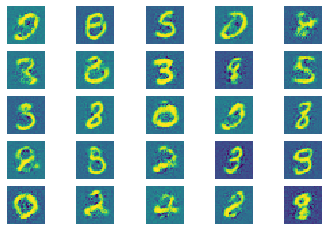

In [29]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

model = load_model('generator_model.h5')
latent_points = generate_latent_points(latent_dim=100, n_samples=25)
X = model.predict(latent_points)

n = 5
for i in range(n * n):
    # define subplot
    pyplot.subplot(n, n, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(X[i, :, :, 0], cmap='viridis')
pyplot.show()

In [25]:
X.shape

(25, 28, 28, 1)